In [ ]:
# https://drive.google.com/file/d/1EhtOuQ8Tr_u-0nquiCZoD8KdBKPf01CX/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EhtOuQ8Tr_u-0nquiCZoD8KdBKPf01CX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EhtOuQ8Tr_u-0nquiCZoD8KdBKPf01CX" -O dataset.zip && rm -rf /tmp/cookies.txt

--2022-01-10 23:02:27--  https://docs.google.com/uc?export=download&confirm=wWBM&id=1EhtOuQ8Tr_u-0nquiCZoD8KdBKPf01CX
Resolving docs.google.com (docs.google.com)... 74.125.204.113, 74.125.204.102, 74.125.204.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.204.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-9c-docs.googleusercontent.com/docs/securesc/88qltbako6u3lvif9c69pg2o4k5mvp06/o293pp1p6aajqt20739lic4pm7eo34sq/1641855675000/10679098327278754895/04689680523548699063Z/1EhtOuQ8Tr_u-0nquiCZoD8KdBKPf01CX?e=download [following]
--2022-01-10 23:02:27--  https://doc-0g-9c-docs.googleusercontent.com/docs/securesc/88qltbako6u3lvif9c69pg2o4k5mvp06/o293pp1p6aajqt20739lic4pm7eo34sq/1641855675000/10679098327278754895/04689680523548699063Z/1EhtOuQ8Tr_u-0nquiCZoD8KdBKPf01CX?e=download
Resolving doc-0g-9c-docs.googleusercontent.com (doc-0g-9c-docs.googleusercontent.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connectin

In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/b

In [ ]:
!pip install pyradiomics

     |████████████████████████████████| 188 kB 4.1 MB/s 
     |████████████████████████████████| 48.4 MB 12 kB/s 
     |████████████████████████████████| 109 kB 52.0 MB/s 
     |████████████████████████████████| 546 kB 51.7 MB/s 


In [ ]:
import os
import re
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

#radiomics
import radiomics
import SimpleITK as sitk
import six
from radiomics import featureextractor
from radiomics import getFeatureClasses, imageoperations


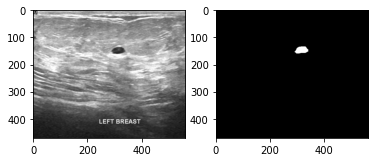

(471, 562, 3)
mask max and min 255 0


In [ ]:
sample_org = cv2.imread("/content/Dataset_BUSI_with_GT/benign/benign (1).png")
sample_msk = cv2.imread("/content/Dataset_BUSI_with_GT/benign/benign (1)_mask.png")
plt.subplot(121)
plt.imshow(sample_org,cmap="gray")
plt.subplot(122)
plt.imshow(sample_msk,cmap="gray")
plt.show()
print(sample_msk.shape)
print("mask max and min", np.max(sample_msk), np.min(sample_msk))

In [ ]:
parent_benign = "/content/Dataset_BUSI_with_GT/benign/"
parent_malignant = "/content/Dataset_BUSI_with_GT/malignant/"
# benign
benign_all = natsorted(os.listdir(parent_benign))
benign_img = [parent_benign+im for im in benign_all if not "_mask" in im and ".png" == im[-4:]]
benign_msk = [parent_benign+ms for ms in benign_all if "_mask" in ms and ".png" == ms[-4:]]
# malignant
malignant_all = natsorted(os.listdir(parent_malignant))
malignant_img = [parent_malignant+im for im in malignant_all if not "_mask" in im and ".png" == im[-4:]]
malignant_msk = [parent_malignant+ms for ms in malignant_all if "_mask" in ms and ".png" == ms[-4:]]
'''
1症例内にmaskが複数あるので同じ数にならない
'''
print("benign all-images-masks", len(benign_all), len(benign_img), len(benign_msk))
print("malignant all-images-masks", len(malignant_all), len(malignant_img), len(malignant_msk))
print("total lesions", len(benign_msk)+len(malignant_msk))

benign all-images-masks 891 437 454
malignant all-images-masks 421 210 211
total lesions 665


In [ ]:
'''
maskを解析対象として、
ID, ラベル, 特徴テーブルを作る
画像とマスクを入力すると、良性・悪性を判定するアプリ
サンプル画像は3枚。画像ファイル名で良性・悪性が分かるように。
画像とマスクのペアが入力されたら、特徴を計算し、予測値を取得。
悪性予測値と、ファイル名を表示。
'''

'\nmaskを解析対象として、\nID, ラベル, 特徴テーブルを作る\n画像とマスクを入力すると、良性・悪性を判定するアプリ\nサンプル画像は3枚。画像ファイル名で良性・悪性が分かるように。\n画像とマスクのペアが入力されたら、特徴を計算し、予測値を取得。\n悪性予測値と、ファイル名を表示。\n'

In [ ]:
def getLesionID(baseName="malignant (34)_mask.png"):
  start = baseName.find("(")+1
  end = baseName.find(")")
  return int(baseName[start:end])


def getSubjID(baseName="malignant (34)_mask.png"):
  end = baseName.find(")")
  return baseName[:end+1]


malignant (34)


In [ ]:
def getImage(images=None, subjID="benign (99).png"):
  for img_path in images:
    basename = os.path.basename(img_path)
    if subjID in img_path:
      im = cv2.imread(img_path)
      if im is not None:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY).astype(np.int8)
      return im
  return None

In [ ]:
# extract features
'''
ピクセルキャリブレーションされているまたは画質統一での検査でない限り、Shape2Dに意味は少ない。
今回は紛らわしいので削除。
'''
def extract_(images=None, masks=None, norm=True):
  settings = {}
  settings['binWidth'] = 25
  # If enabled, resample image (resampled image is automatically cropped.
  settings['resampledPixelSpacing'] = None # [3,3,3] is an example for defining resampling (v
  settings['interpolator'] = sitk.sitkBSpline
  settings['label'] = 1
  settings['force2D'] = True
  # settings['correctMask'] = True #
  extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
  df_ = None
  for mask_path in masks:
    if not ".png" == mask_path[-4:]:
      continue 
    basename = os.path.basename(mask_path)
    subjID = getSubjID(baseName=basename)
    lbl = int(1 if "malignant" in basename else 0)
    mask = cv2.imread(mask_path) # BGR
    if mask is None:
      raise ValueError('Mask checks failed when image loading...')
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.where(mask > 0, 1, 0).astype(np.int8)
    mask = np.expand_dims(mask, axis=0)
    img = getImage(images, subjID)
    if img is None:
      raise ValueError('Image loading failed . Can not find image file.')
    img = np.expand_dims(img, axis=0)
    # to sitk image
    img = sitk.GetImageFromArray(img)
    mask = sitk.GetImageFromArray(mask)
    if norm:
      img = imageoperations.normalizeImage(img)
      bb, correctedMask = imageoperations.checkMask(img, mask)
    if correctedMask is not None:
      # Update the mask if it had to be resampled
      mask = correctedMask
    if bb is None: # boundingBox
      # Mask checks failed
      raise ValueError('Mask checks failed during pre-crop')
    img, mask = imageoperations.cropToTumorMask(img, mask, bb)
    # shapes = extractor.computeShape(img, mask, bb)
    textures = extractor.computeFeatures(img,mask,"original")
    # shape_values = {}
    # for key, val in six.iteritems(shapes):
    #   shape_values[key] = [val]
    # shape_df = pd.DataFrame(shape_values)
    texture_values = {}
    for key, val in six.iteritems(textures):
      texture_values[key] = [val]
    texture_df = pd.DataFrame(texture_values)
    # row_ = pd.concat([shape_df, texture_df], axis=1)
    row_ = texture_df # no cancat to shape
    row_["LABEL"] = lbl
    row_["ID"] = subjID
    if df_ is None:
      df_ = row_.copy()
    else:
      df_ = df_.append(row_, ignore_index=True)
  return df_


In [ ]:
# pre-fetch for test samples on streamlit.
benign4sample = benign_msk[-5:]
malignant4sample = malignant_msk[-5:]
print(benign4sample, malignant4sample)

['/content/Dataset_BUSI_with_GT/benign/benign (433)_mask.png', '/content/Dataset_BUSI_with_GT/benign/benign (434)_mask.png', '/content/Dataset_BUSI_with_GT/benign/benign (435)_mask.png', '/content/Dataset_BUSI_with_GT/benign/benign (436)_mask.png', '/content/Dataset_BUSI_with_GT/benign/benign (437)_mask.png'] ['/content/Dataset_BUSI_with_GT/malignant/malignant (206)_mask.png', '/content/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png', '/content/Dataset_BUSI_with_GT/malignant/malignant (208)_mask.png', '/content/Dataset_BUSI_with_GT/malignant/malignant (209)_mask.png', '/content/Dataset_BUSI_with_GT/malignant/malignant (210)_mask.png']


In [ ]:
# all images and masks for build a model.
images = benign_img + malignant_img
masks = benign_msk[:-5] + malignant_msk[:-5] # exclude sample
res = extract_(images, masks, norm=True)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Avera

In [ ]:
res.to_csv("radiomics_features.csv")

In [ ]:
print(res.shape)

(655, 95)


In [ ]:
import sklearn
print(sklearn.__version__) # 1.0.1

1.0.1


In [ ]:
# create a model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold
# evaluation
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

def build_model(csv_path="", norm=True):
  features = pd.read_csv(csv_path, index_col=0)
  print(features.shape)
  X = features.drop(["LABEL","ID"], axis=1)
  y = features["LABEL"].copy()
  iDs = features["ID"].copy()
  print("original csv shape", features.shape)
  print("X:droped label and id", X.shape)
  print("y(benign:0, malignant:1)", y.shape)
  print("iDs(subj-id)", iDs.shape)
  cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=76)
  # iterate only once.
  for train_idxs, test_idxs in cv.split(X, y, iDs):
    train_X = X.values[train_idxs]
    train_y = y.values[train_idxs]
    val_X = X.values[test_idxs]
    val_y = y.values[test_idxs]
    if norm:
      scaler = StandardScaler()
      scaler.fit(train_X)
      train_X = scaler.transform(train_X)
      val_X = scaler.transform(val_X)
    clf = LogisticRegression(penalty="elasticnet", solver="saga", l1_ratio=0.8, random_state=76)
    clf.fit(train_X, train_y)
    break
  # evaluate
  pred = clf.predict(val_X)
  fpr, tpr, thresholds = roc_curve(val_y, pred)
  auc_val = roc_auc_score(val_y, pred)
  plt.title(" ROC "+" (auc:"+str(round(auc_val,2))+")")
  plt.plot(fpr, tpr, marker='o')
  plt.xlabel('FPR: False positive rate')
  plt.ylabel('TPR: True positive rate')
  plt.show()
  plt.pause(0.01)
  target_names = ['benign', 'malignant']
  pred_lbl = [int(1) if p > 0.5 else int(0) for p in pred]
  print(classification_report(val_y, np.array(pred_lbl), target_names=target_names))
  if norm :
    scaler_mean_df = pd.DataFrame(scaler.mean_.reshape((1,len(X.columns))), columns=X.columns)
    scaler_var_df = pd.DataFrame(scaler.var_.reshape((1,len(X.columns))), columns=X.columns)
    mean_and_var = scaler_mean_df.append(scaler_var_df, ignore_index=True)
    return clf, mean_and_var
  else:
    return clf, None


(655, 95)
original csv shape (655, 95)
X:droped label and id (655, 93)
y(benign:0, malignant:1) (655,)
iDs(subj-id) (655,)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


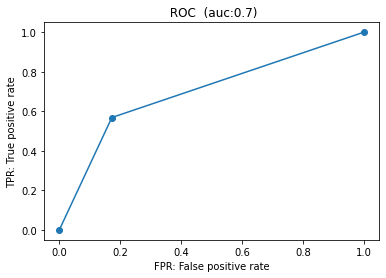

              precision    recall  f1-score   support

      benign       0.81      0.83      0.82       110
   malignant       0.60      0.57      0.59        51

    accuracy                           0.75       161
   macro avg       0.70      0.70      0.70       161
weighted avg       0.74      0.75      0.74       161



In [ ]:
clf, scaler_mean_var = build_model(csv_path="radiomics_features.csv", norm=True)

In [ ]:
print(scaler_mean_var.shape)
scaler_mean_var.to_csv("scaler_mean_and_variance.csv")

(2, 93)


In [ ]:
# save model
import pickle
filename = 'model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
# 画像から予測結果を取得する

def get_features(img_path=None, mask_path=None, norm=True):
  settings = {}
  settings['binWidth'] = 25
  # If enabled, resample image (resampled image is automatically cropped.
  settings['resampledPixelSpacing'] = None # [3,3,3] is an example for defining resampling (v
  settings['interpolator'] = sitk.sitkBSpline
  settings['label'] = 1
  settings['force2D'] = True
  # settings['correctMask'] = True #
  extractor = featureextractor.RadiomicsFeatureExtractor(*settings)
  mask = cv2.imread(mask_path) # BGR
  if mask is None:
    raise ValueError('Mask checks failed when image loading...')
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask = np.where(mask > 0, 1, 0).astype(np.int8)
  mask = np.expand_dims(mask, axis=0)

  img = cv2.imread(img_path)
  if img is None:
      raise ValueError('Image loading failed . Can not find image file.')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.int8)
  img = np.expand_dims(img, axis=0)
  # to sitk image
  img = sitk.GetImageFromArray(img)
  mask = sitk.GetImageFromArray(mask)
  if norm:
    img = imageoperations.normalizeImage(img)
    bb, correctedMask = imageoperations.checkMask(img, mask)
  if correctedMask is not None:
    # Update the mask if it had to be resampled
    mask = correctedMask
  if bb is None: # boundingBox
    # Mask checks failed
    raise ValueError('Mask checks failed during pre-crop')
  img, mask = imageoperations.cropToTumorMask(img, mask, bb)
  # shapes = extractor.computeShape(img, mask, bb)
  textures = extractor.computeFeatures(img, mask, "original")
  # shape_values = {}
  # for key, val in six.iteritems(shapes):
  #   shape_values[key] = [val]
  # shape_df = pd.DataFrame(shape_values)
  texture_values = {}
  for key, val in six.iteritems(textures):
    texture_values[key] = [val]
  texture_df = pd.DataFrame(texture_values)
  return texture_df.copy()


def do_predict(model_path=None, img_path="", mask_path="", norm=True, scaler_mean_var_path=None):
  if norm:
    if scaler_mean_var_path is None:
      raise ValueError('Standardization was failed . Please set scale maen and sigma.')
    scaler_mean_var = pd.read_csv(scaler_mean_var_path, index_col=0)
  loaded_model = pickle.load(open(model_path, 'rb'))
  f_ = get_features(img_path, mask_path, norm=True)
  f_norm = (f_[:1].values - scaler_mean_var[:1].values) / np.sqrt(scaler_mean_var[1:2].values)
  result = loaded_model.predict(f_norm)
  proba = loaded_model.predict_proba(f_norm)
  basename = os.path.basename(mask_path)
  ans = int(1 if "malignant" in basename else 0)
  title = ""
  if ans == 0:
    # correct ?
    if int(result) == ans:
      title += "benign, success,"
    else:
      title += "benign, error,"
  else:
    if int(result) == ans:
      title += "malignant, success,"
    else:
      title += "malignant, error,"
  title += str(round(proba[0][int(ans)],2))
  plt.figure()
  print(title)
  # plt.title("test")
  plt.subplot(1,2,1, title=title)
  plt.imshow(cv2.imread(img_path))
  plt.subplot(1,2,2)
  plt.imshow(cv2.imread(mask_path))
  plt.show()
  plt.pause(0.01)

In [ ]:
# sample
# masks
s0_mask = '/content/Dataset_BUSI_with_GT/benign/benign (433)_mask.png'
s1_mask = '/content/Dataset_BUSI_with_GT/benign/benign (434)_mask.png'
s2_mask = '/content/Dataset_BUSI_with_GT/benign/benign (435)_mask.png'
s3_mask = '/content/Dataset_BUSI_with_GT/benign/benign (436)_mask.png'
s4_mask = '/content/Dataset_BUSI_with_GT/benign/benign (437)_mask.png'
s5_mask = '/content/Dataset_BUSI_with_GT/malignant/malignant (206)_mask.png'
s6_mask = '/content/Dataset_BUSI_with_GT/malignant/malignant (207)_mask.png'
s7_mask = '/content/Dataset_BUSI_with_GT/malignant/malignant (208)_mask.png'
s8_mask = '/content/Dataset_BUSI_with_GT/malignant/malignant (209)_mask.png'
s9_mask = '/content/Dataset_BUSI_with_GT/malignant/malignant (210)_mask.png'
# images
s0_img = '/content/Dataset_BUSI_with_GT/benign/benign (433).png'
s1_img = '/content/Dataset_BUSI_with_GT/benign/benign (434).png'
s2_img = '/content/Dataset_BUSI_with_GT/benign/benign (435).png'
s3_img = '/content/Dataset_BUSI_with_GT/benign/benign (436).png'
s4_img = '/content/Dataset_BUSI_with_GT/benign/benign (437).png'
s5_img = '/content/Dataset_BUSI_with_GT/malignant/malignant (206).png'
s6_img = '/content/Dataset_BUSI_with_GT/malignant/malignant (207).png'
s7_img = '/content/Dataset_BUSI_with_GT/malignant/malignant (208).png'
s8_img = '/content/Dataset_BUSI_with_GT/malignant/malignant (209).png'
s9_img = '/content/Dataset_BUSI_with_GT/malignant/malignant (210).png'

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


benign, success,0.94


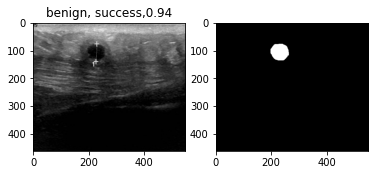

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


benign, success,0.57


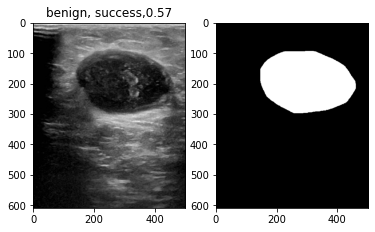

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


benign, success,0.95


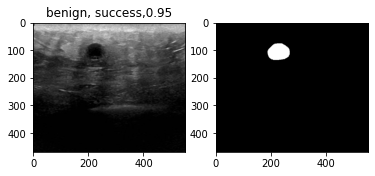

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


benign, success,0.59


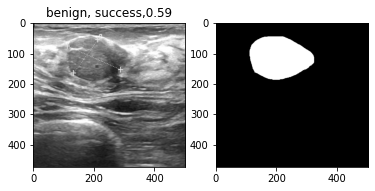

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


benign, success,0.97


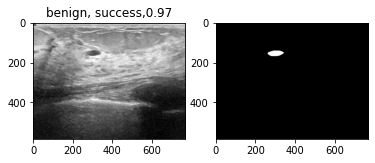

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


malignant, success,0.63


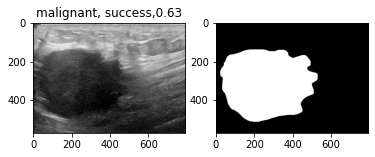

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


malignant ?, error,0.43


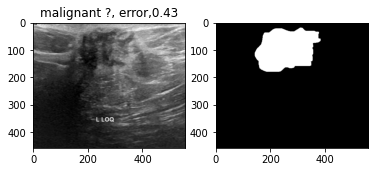

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


malignant, success,0.78


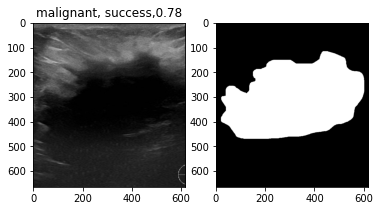

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


malignant ?, error,0.19


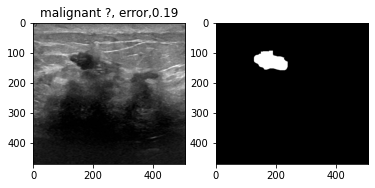

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


malignant ?, error,0.0


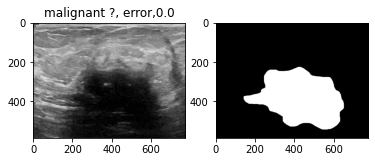

In [ ]:
do_predict(model_path=filename, img_path=s0_img, mask_path=s0_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s1_img, mask_path=s1_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s2_img, mask_path=s2_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s3_img, mask_path=s3_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s4_img, mask_path=s4_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s5_img, mask_path=s5_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s6_img, mask_path=s6_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s7_img, mask_path=s7_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s8_img, mask_path=s8_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")
do_predict(model_path=filename, img_path=s9_img, mask_path=s9_mask, norm=True, scaler_mean_var_path="/content/scaler_mean_and_variance.csv")

# References

1.   https://www.kaggle.com/omkarmodi/mobilenetv2-feature-extraction/data
2.   

